## AppleJack BnLearn Training Structure & Parameter Learning & GranularNiche Model 5000 v6.2

In [1]:
import pgmpy as p
import bnlearn as bn
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BDeuScore, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from bnlearn import structure_learning
from bnlearn import parameter_learning
from pgmpy.inference import VariableElimination
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import beta

### Training

In [2]:
# Read the CSV file and skip the "Unnamed" column
ground_truth_df = pd.read_csv("GT168000_train_data.csv", index_col=0)
ground_truth_df.head()

,LatVar1,Drought,LatVar2,DryFarm,LatVar3,LowSoilMoisture,LatVar4,DryTree,BadTreeCondition,SickTree,BadCropCondition,LatVar5,LoseLeaves,LatVar6
197431,0,0,0,0,1,1,0,1,1,0,1,1,0,0
28215,0,1,1,1,0,1,1,1,1,0,1,1,1,1
140772,0,0,0,0,1,0,0,1,1,0,0,0,0,0
32671,0,1,1,1,1,0,0,0,0,0,0,1,1,1
75621,0,0,1,1,1,1,1,1,0,0,0,1,1,0


In [3]:
# Define the structure
model_structure = [('Drought', 'DryFarm'), ('DryFarm', 'LowSoilMoisture'), ('LowSoilMoisture', 'DryTree'), ('DryTree', 'BadTreeCondition'), ('SickTree', 'BadTreeCondition'), ('BadTreeCondition', 'BadCropCondition'), ('BadTreeCondition', 'LoseLeaves')]

# Create the BayesianModel
model = BayesianNetwork(model_structure)

In [4]:
# Defining all the conditional probabilities tables by a method in pgmpy called TabularCPD
cpd_dr = TabularCPD(variable='Drought', variable_card=2, values=[[0.8399], [0.1601]])
cpd_st = TabularCPD(variable='SickTree', variable_card=2, values=[[0.8399],[0.1601]])


cpd_df = TabularCPD(variable='DryFarm', variable_card=2, 
                    values=[[0.7950, 0.2050 ],
                            [0.2050, 0.7950]],
                    evidence=['Drought'],
                    evidence_card=[2])

cpd_lsm = TabularCPD(variable='LowSoilMoisture', variable_card=2, 
                    values=[[0.6464, 0.3536],
                            [0.3536, 0.6464]],
                    evidence=['DryFarm'],
                    evidence_card=[2])

cpd_dt = TabularCPD(variable='DryTree', variable_card=2, 
                    values=[[0.7900, 0.2100],
                            [0.2100, 0.7900]],
                    evidence=['LowSoilMoisture'],
                    evidence_card=[2])

cpd_btc = TabularCPD(variable='BadTreeCondition', variable_card=2, 
                    values=[[0.7647, 0.7300, 0.6450, 0.4751],
                            [0.2353, 0.2700, 0.3550, 0.5249]],
                    evidence=['DryTree','SickTree'],
                    evidence_card=[2, 2])

cpd_ll = TabularCPD(variable='LoseLeaves', variable_card=2, 
                    values=[[0.7949, 0.2051],
                            [0.2051, 0.7949]],
                    evidence=['BadTreeCondition'],
                    evidence_card=[2])

cpd_bcc = TabularCPD(variable='BadCropCondition', variable_card=2, 
                    values=[[0.7303, 0.2697],
                           [0.2697, 0.7303]],
                    evidence=['BadTreeCondition'],
                    evidence_card=[2])

In [5]:
# Add the conditional probability tables to the model
model.add_cpds(cpd_dr, cpd_dt, cpd_st, cpd_df, cpd_lsm, cpd_btc, cpd_bcc, cpd_ll)

In [6]:
# Check if the model is valid
model.check_model()

True

In [7]:
# Create a BayesianModelSampling object with the model
sampler = BayesianModelSampling(model)

In [8]:
# Use Bayesian Parameter Estimation to refine the parameter estimates
# Set the number of samples and Dirichlet hyperparameters
n = 5000

In [9]:
# Generate 5000 samples from the model using forward sampling
samples = sampler.forward_sample(size=5000)

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
# Convert the samples to DataFrame format
samples_df = pd.DataFrame(samples)

In [11]:
df = samples_df

In [12]:
# Write the DataFrame to a CSV file
df.to_csv("GTGN5000_train_data.csv", index=False)

In [13]:
# Read the CSV file and skip the "Unnamed" column
ground_truth_df = pd.read_csv("GTGN5000_train_data.csv", index_col=0)
ground_truth_df.head()

,DryFarm,LowSoilMoisture,DryTree,BadTreeCondition,SickTree,BadCropCondition,LoseLeaves
Drought,,,,,,,
0,1,1,0,1,0,1,1
0,0,1,1,1,0,1,1
0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,1


In [14]:
# Define the structure
model_structure = [('Drought', 'DryFarm'), ('DryFarm', 'LowSoilMoisture'), ('LowSoilMoisture', 'DryTree'), ('DryTree', 'BadTreeCondition'), ('SickTree', 'BadTreeCondition'), ('BadTreeCondition', 'BadCropCondition'), ('BadTreeCondition', 'LoseLeaves')]

# Create the BayesianModel
model = BayesianNetwork(model_structure)

In [15]:
# Alpha and Beta hyperparameters
alpha = 80
beta = 20

# Total count for initial probability calculation
total_count = 100

# Function to calculate new probabilities with alpha-beta adjustments
def adjust_probs(prob, alpha, beta, total_count):
    count = prob * total_count
    adjusted_count_0 = count + alpha
    adjusted_count_1 = (total_count - count) + beta
    total_adjusted_count = adjusted_count_0 + adjusted_count_1
    return adjusted_count_0 / total_adjusted_count, adjusted_count_1 / total_adjusted_count

# CPDs for each variable
# CPD for DryFarm
prob_dryfarm_0, prob_dryfarm_1 = adjust_probs(0.565333, alpha, beta, total_count)
cpd_dryfarm = TabularCPD(variable='DryFarm', variable_card=2, values=[[prob_dryfarm_0], [prob_dryfarm_1]])

# CPD for LowSoilMoisture
prob_lowsoilmoisture_00, prob_lowsoilmoisture_01 = adjust_probs(0.558962, alpha, beta, total_count)
prob_lowsoilmoisture_10, prob_lowsoilmoisture_11 = adjust_probs(0.441038, beta, alpha, total_count)
cpd_lowsoilmoisture = TabularCPD(variable='LowSoilMoisture', variable_card=2, 
                                 values=[[prob_lowsoilmoisture_00, prob_lowsoilmoisture_01],
                                         [prob_lowsoilmoisture_10, prob_lowsoilmoisture_11]],
                                 evidence=['DryFarm'], evidence_card=[2])

# CPD for DryTree
prob_drytree_00, prob_drytree_01 = adjust_probs(0.615482, alpha, beta, total_count)
prob_drytree_10, prob_drytree_11 = adjust_probs(0.384518, beta, alpha, total_count)
cpd_drytree = TabularCPD(variable='DryTree', variable_card=2, 
                         values=[[prob_drytree_00, prob_drytree_01],
                                 [prob_drytree_10, prob_drytree_11]],
                         evidence=['LowSoilMoisture'], evidence_card=[2])

# CPD for LoseLeaves
prob_loseleaves_0, prob_loseleaves_1 = adjust_probs(0.531333, alpha, beta, total_count)
cpd_loseleaves = TabularCPD(variable='LoseLeaves', variable_card=2, values=[[prob_loseleaves_0], [prob_loseleaves_1]])

# CPD for BadTreeCondition
prob_badtreecondition_00, prob_badtreecondition_01 = adjust_probs(0.638645, alpha, beta, total_count)
prob_badtreecondition_10, prob_badtreecondition_11 = adjust_probs(0.361355, beta, alpha, total_count)
cpd_badtreecondition = TabularCPD(variable='BadTreeCondition', variable_card=2,
                        values=[[prob_badtreecondition_00, prob_badtreecondition_01],
                               [prob_badtreecondition_10, prob_badtreecondition_11]],
                        evidence=['LoseLeaves'], evidence_card=[2])

# CPD for BadCropCondition
prob_badcropcondition_00, prob_badcropcondition_01 = adjust_probs(0.584653, alpha, beta, total_count)
prob_badcropcondition_10, prob_badcropcondition_11 = adjust_probs(0.415347, beta, alpha, total_count)
cpd_badcropcondition = TabularCPD(variable='BadCropCondition', variable_card=2,
                        values=[[prob_badcropcondition_00, prob_badcropcondition_01],
                               [prob_badcropcondition_10, prob_badcropcondition_11]],
                        evidence=['BadTreeCondition'], evidence_card=[2])

In [16]:
# Associating the CPDs with the network
model = BayesianModel(model)
model.add_cpds(cpd_dr, cpd_df, cpd_lsm, cpd_dt, cpd_btc, cpd_ll, cpd_bcc)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


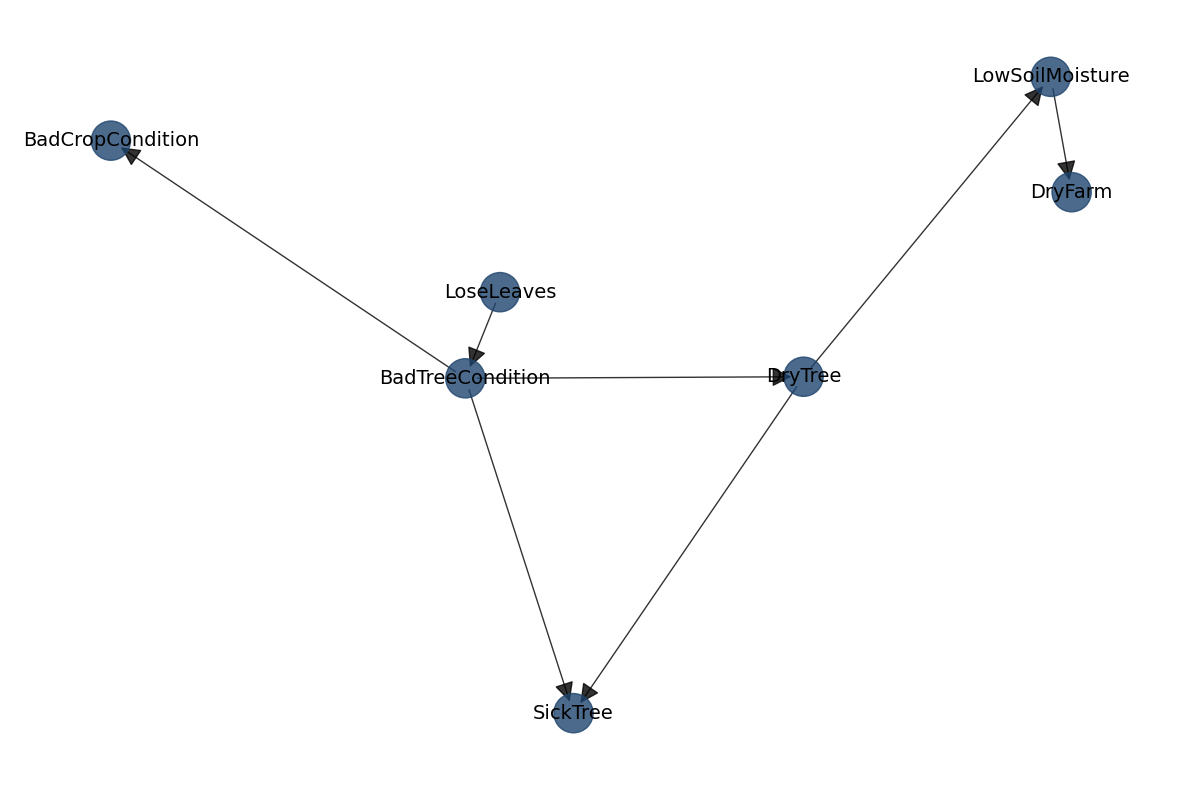

In [17]:
model = bn.structure_learning.fit(ground_truth_df)
G = bn.plot(model)

###  BIC Scores

In [18]:
# Define the HillClimbSearch object
hc = HillClimbSearch(ground_truth_df)

In [19]:
# Perform the structure learning with BIC scoring
scoring_method = BicScore(ground_truth_df)
best_model = hc.estimate(scoring_method)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
# Print the learned structure (edges)
print("Learned edges:")
print(best_model.edges())

Learned edges:
[('LowSoilMoisture', 'DryFarm'), ('DryTree', 'LowSoilMoisture'), ('DryTree', 'SickTree'), ('BadTreeCondition', 'BadCropCondition'), ('BadTreeCondition', 'DryTree'), ('BadTreeCondition', 'SickTree'), ('LoseLeaves', 'BadTreeCondition')]


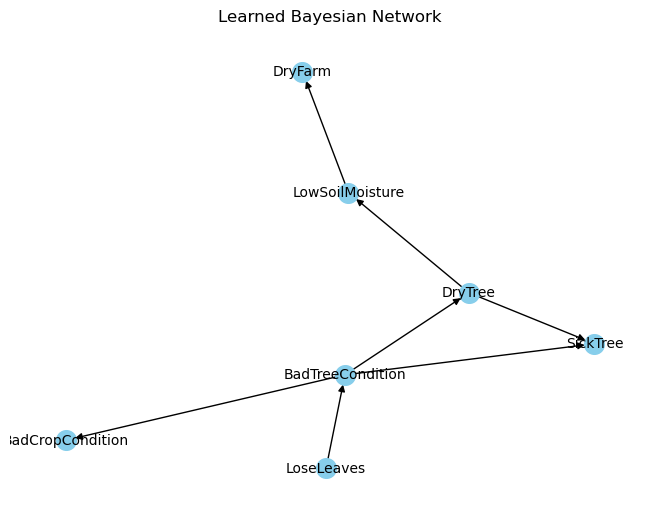

In [21]:
# Create a Directed Graph (DiGraph) to visualize the Bayesian network
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(best_model.nodes())

# Add edges to the graph based on the learned structure
G.add_edges_from(best_model.edges())

# Plot the Bayesian network
pos = nx.spring_layout(G, seed=42)  # You can choose different layout algorithms
nx.draw(G, pos, with_labels=True, node_size=200, node_color="Skyblue", font_size=10, font_color="black", font_weight="regular")
plt.title("Learned Bayesian Network")
plt.show()

In [22]:
# Perform the structure learning with BIC scoring
scoring_method = BicScore(ground_truth_df)
bic_scores = []

In [23]:
# Create BicScore object
bic_score = BicScore(ground_truth_df)

In [24]:
# Calculate and print BIC score for the given network structure
bic_network_score = bic_score.score(best_model)

In [25]:
# Number of iterations
num_iterations = 10

for _ in range(num_iterations):
    # Estimate the best model
    best_model = hc.estimate(scoring_method)
    
    # Calculate BIC score for the given network structure
    bic_network_score = scoring_method.score(best_model)
    bic_scores.append(bic_network_score)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [26]:
# Calculate mean and standard deviation of BIC scores
bic_mean = np.mean(bic_scores)
bic_std_dev = np.std(bic_scores)

In [27]:
print(f"Mean BIC Score: {bic_mean}")
print(f"Standard Deviation of BIC Scores: {bic_std_dev}")

Mean BIC Score: -19490.30298696863
Standard Deviation of BIC Scores: 0.0


In [28]:
model_update = bn.parameter_learning.fit(model, ground_truth_df, methodtype='bayes')

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of LowSoilMoisture:
+--------------------+---------------------+---------------------+
| DryTree            | DryTree(0)          | DryTree(1)          |
+--------------------+---------------------+---------------------+
| LowSoilMoisture(0) | 0.7766056469128142  | 0.30176449405833633 |
+--------------------+---------------------+---------------------+
| LowSoilMoisture(1) | 0.22339435308718586 | 0.6982355059416636  |
+--------------------+---------------------+---------------------+
[bnlearn] >CPD of DryFarm:
+-----------------+---------------------+--------------------+
| LowSoilMoisture | LowSoilMoisture(0)  | LowSoilMoisture(1) |
+-----------------+---------------------+--------------------+
| DryFarm(0)      | 0.7551631248129302  | 0.5317788642346747 |
+-----------------+----

### Validation KL Divergence 

### BadTreeCondition & BadCropCondition

In [29]:
from scipy.special import kl_div

In [30]:
# Generate 5000 samples from the ground truth model
ground_truth_samples = ground_truth_df.sample(n=5000, random_state=1)
ground_truth_samples_df = pd.DataFrame(ground_truth_samples)

In [31]:
# Create empty lists to store KL Divergence values
kl_divergence_list1 = []
kl_divergence_list2 = []

In [32]:
# Number of iterations
num_iterations = 10

In [33]:
# Number of iterations
num_iterations = 10
sample_size = 5000  # Sample size should not exceed the population size

for _ in range(num_iterations):
    # Take n samples from the CPD distribution
    data_df = bn.sampling(model_update, n=sample_size, methodtype='bayes')
    
    # Generate samples from the ground truth model
    ground_truth_samples = ground_truth_df.sample(n=sample_size, random_state=1)
    ground_truth_samples_df = pd.DataFrame(ground_truth_samples)
    
    # Perform KL divergence analysis for the full conditional distribution between the baseline model and the ground truth model
    kl_divergence1 = kl_div(ground_truth_samples_df['BadTreeCondition'].value_counts(normalize=True),
                           data_df['BadTreeCondition'].value_counts(normalize=True))
    
    kl_divergence_list1.append(kl_divergence1)
    
    # Perform KL divergence analysis for another distribution (you can add more as needed)
    kl_divergence2 = kl_div(ground_truth_samples_df['BadCropCondition'].value_counts(normalize=True),
                           data_df['BadCropCondition'].value_counts(normalize=True))
    
    kl_divergence_list2.append(kl_divergence2)

In [34]:
# Calculate mean and standard deviation of KL Divergence values
kl_divergence_mean1 = np.mean(kl_divergence_list1)
kl_divergence_std_dev1 = np.std(kl_divergence_list1)

kl_divergence_mean2 = np.mean(kl_divergence_list2)
kl_divergence_std_dev2 = np.std(kl_divergence_list2)

In [35]:
print(f"Mean KL Divergence 1: {kl_divergence_mean1}")
print(f"Standard Deviation KL Divergence 1: {kl_divergence_std_dev1}")

print(f"Mean KL Divergence 2: {kl_divergence_mean2}")
print(f"Standard Deviation KL Divergence 2: {kl_divergence_std_dev2}")

Mean KL Divergence 1: 0.0010366276049795064
Standard Deviation KL Divergence 1: 0.000539507025195717
Mean KL Divergence 2: 0.00022990962890764854
Standard Deviation KL Divergence 2: 0.00021750521436916294


### BIC Score Validation Data

In [47]:
# Read the CSV file and skip the "Unnamed" column
ground_truth_df = pd.read_csv("GT72000_val_data.csv", index_col=0)
ground_truth_df.head()

,LatVar1,Drought,LatVar2,DryFarm,LatVar3,LowSoilMoisture,LatVar4,DryTree,BadTreeCondition,SickTree,BadCropCondition,LatVar5,LoseLeaves,LatVar6
202827,1,0,1,1,1,0,0,0,0,0,0,0,0,0
151507,0,1,1,1,0,0,0,0,1,1,1,1,1,1
163248,0,0,0,0,1,1,0,1,0,0,1,1,0,0
157083,0,1,1,1,1,0,1,0,0,0,0,1,1,1
69269,1,0,1,1,1,1,0,1,1,0,1,1,1,0


In [36]:
# Defining the model structure by passing a list of edges
model_update = BayesianModel([('LowSoilMoisture', 'DryFarm'), ('DryTree', 'LowSoilMoisture'), ('DryTree', 'SickTree'), ('BadTreeCondition', 'BadCropCondition'), ('BadTreeCondition', 'DryTree'), ('BadTreeCondition', 'SickTree'), ('LoseLeaves', 'BadTreeCondition')])
DAG =  bn.make_DAG(model_update)

[bnlearn] >No changes made to existing bayes DAG.


In [37]:
# Use Bayesian Parameter Estimation to refine the parameter estimates
# Set the number of samples and Dirichlet hyperparameters
n = 5000

In [38]:
# Generate 5000 samples from the model using forward sampling
samples = sampler.forward_sample(size = 5000)

  0%|          | 0/8 [00:00<?, ?it/s]

In [39]:
# Convert the samples to DataFrame format
samples_df = pd.DataFrame(samples)

In [40]:
print(samples_df)

      Drought  DryFarm  LowSoilMoisture  DryTree  BadTreeCondition  SickTree  \
0           1        1                0        1                 0         0   
1           0        0                0        0                 0         1   
2           0        1                1        0                 0         0   
3           0        0                0        0                 1         0   
4           0        0                0        0                 0         0   
...       ...      ...              ...      ...               ...       ...   
4995        0        0                0        0                 0         0   
4996        0        0                0        0                 1         0   
4997        0        0                0        0                 0         0   
4998        0        0                0        0                 0         0   
4999        0        1                1        1                 0         0   

      BadCropCondition  LoseLeaves  
0 

In [41]:
# Write the DataFrame to a CSV file
df.to_csv("GTGN5000_validation_data.csv", index=False)

In [42]:
# Read the CSV file and skip the "Unnamed" column
ground_truth_df = pd.read_csv("GTGN5000_validation_data.csv", index_col=0)
ground_truth_df.head()

,DryFarm,LowSoilMoisture,DryTree,BadTreeCondition,SickTree,BadCropCondition,LoseLeaves
Drought,,,,,,,
0,1,1,0,1,0,1,1
0,0,1,1,1,0,1,1
0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,1


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


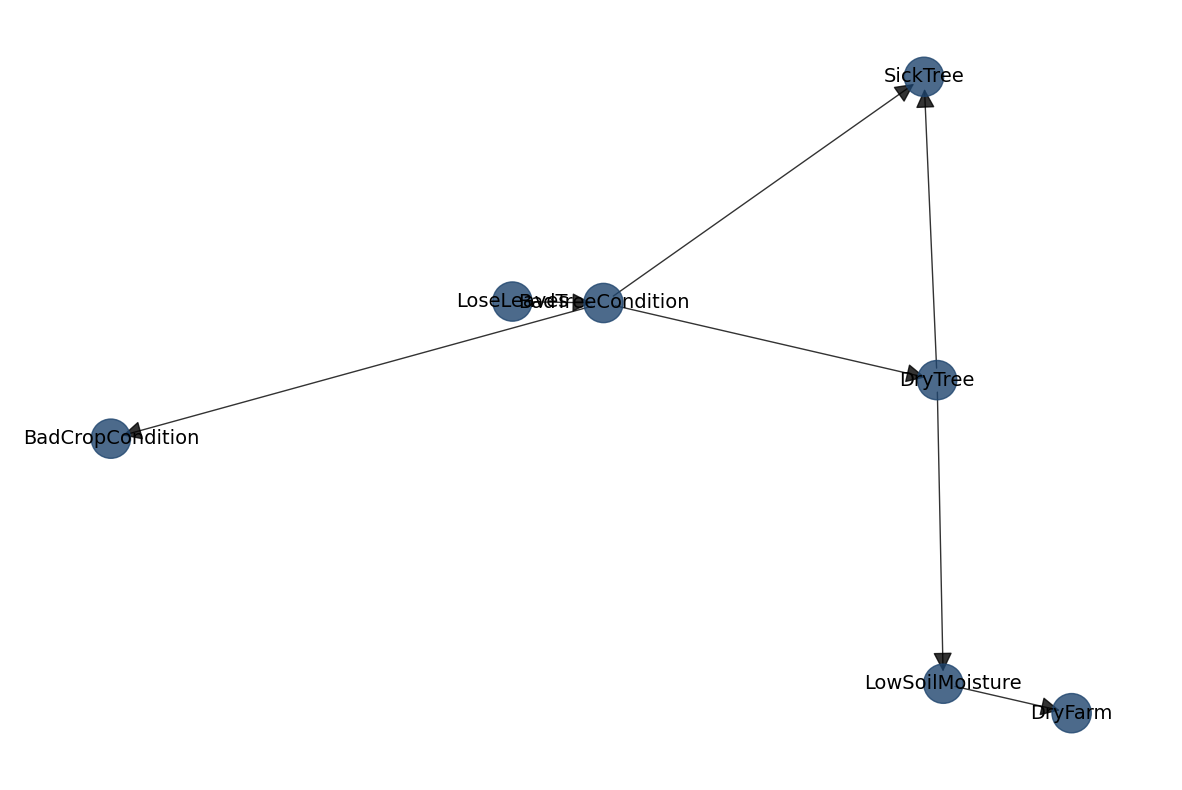

In [43]:
model = bn.structure_learning.fit(ground_truth_df)
G = bn.plot(model)

In [44]:
# Print the learned structure (edges)
print("Learned edges:")
print(best_model.edges())

Learned edges:
[('LowSoilMoisture', 'DryFarm'), ('DryTree', 'LowSoilMoisture'), ('DryTree', 'SickTree'), ('BadTreeCondition', 'BadCropCondition'), ('BadTreeCondition', 'DryTree'), ('BadTreeCondition', 'SickTree'), ('LoseLeaves', 'BadTreeCondition')]


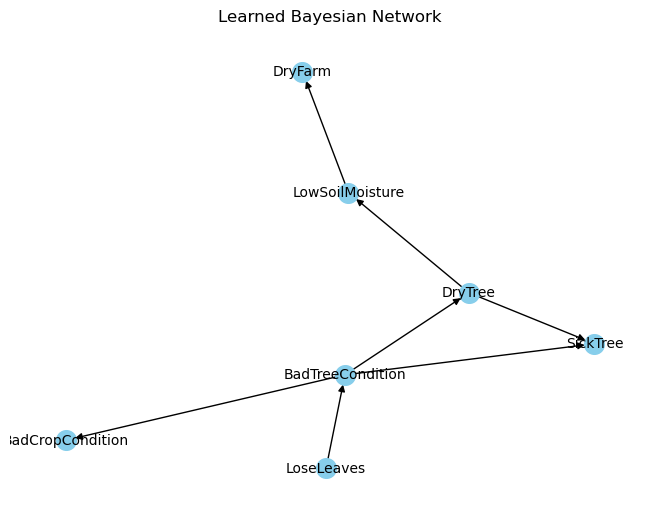

In [45]:
# Create a Directed Graph (DiGraph) to visualize the Bayesian network
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(best_model.nodes())

# Add edges to the graph based on the learned structure
G.add_edges_from(best_model.edges())

# Plot the Bayesian network
pos = nx.spring_layout(G, seed=42)  # You can choose different layout algorithms
nx.draw(G, pos, with_labels=True, node_size=200, node_color="Skyblue", font_size=10, font_color="black", font_weight="regular")
plt.title("Learned Bayesian Network")
plt.show()

###  BIC Scores

In [46]:
# Define the HillClimbSearch object
hc = HillClimbSearch(data_df)

In [47]:
# Perform the structure learning with BIC scoring
scoring_method = BicScore(data_df)
bic_scores = []

In [48]:
# Perform the structure learning with BIC scoring
scoring_method = BicScore(data_df)
best_model = hc.estimate(scoring_method)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [49]:
# Number of iterations
num_iterations = 10

for _ in range(num_iterations):
    # Estimate the best model
    best_model = hc.estimate(scoring_method)
    
    # Calculate BIC score for the given network structure
    bic_network_score = scoring_method.score(best_model)
    bic_scores.append(bic_network_score)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [50]:
print(f"Mean BIC Score: {bic_mean}")
print(f"Standard Deviation of BIC Scores: {bic_std_dev}")

Mean BIC Score: -19490.30298696863
Standard Deviation of BIC Scores: 0.0


In [51]:
model_update = bn.parameter_learning.fit(model, ground_truth_df, methodtype='bayes')

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of LowSoilMoisture:
+--------------------+---------------------+---------------------+
| DryTree            | DryTree(0)          | DryTree(1)          |
+--------------------+---------------------+---------------------+
| LowSoilMoisture(0) | 0.7766056469128142  | 0.30176449405833633 |
+--------------------+---------------------+---------------------+
| LowSoilMoisture(1) | 0.22339435308718586 | 0.6982355059416636  |
+--------------------+---------------------+---------------------+
[bnlearn] >CPD of DryFarm:
+-----------------+---------------------+--------------------+
| LowSoilMoisture | LowSoilMoisture(0)  | LowSoilMoisture(1) |
+-----------------+---------------------+--------------------+
| DryFarm(0)      | 0.7551631248129302  | 0.5317788642346747 |
+-----------------+----

### Validation KL Divergence 5000

### BadTreeCondition & BadCropCondition

In [52]:
from scipy.special import kl_div

In [53]:
# KL Divergence
# Generate 5000 samples from the ground truth model
ground_truth_samples = data_df.sample(n=5000, random_state=1)
ground_truth_samples_df = pd.DataFrame(ground_truth_samples)

In [54]:
# Create empty lists to store KL Divergence values
kl_divergence_list1 = []
kl_divergence_list2 = []

In [55]:
# Number of iterations
num_iterations = 10

In [56]:
# Number of iterations
num_iterations = 10
sample_size = 5000  # Sample size should not exceed the population size

for _ in range(num_iterations):
    # Take n samples from the CPD distribution
    data_df = bn.sampling(model_update, n=sample_size, methodtype='bayes')
    
    # Generate samples from the ground truth model
    ground_truth_samples = ground_truth_df.sample(n=sample_size, random_state=1)
    ground_truth_samples_df = pd.DataFrame(ground_truth_samples)
    
    # Perform KL divergence analysis for the full conditional distribution between the baseline model and the ground truth model
    kl_divergence1 = kl_div(ground_truth_samples_df['BadTreeCondition'].value_counts(normalize=True),
                           data_df['BadTreeCondition'].value_counts(normalize=True))
    
    kl_divergence_list1.append(kl_divergence1)
    
    # Perform KL divergence analysis for another distribution (you can add more as needed)
    kl_divergence2 = kl_div(ground_truth_samples_df['BadCropCondition'].value_counts(normalize=True),
                           data_df['BadCropCondition'].value_counts(normalize=True))
    
    kl_divergence_list2.append(kl_divergence2)

In [57]:
# Calculate mean and standard deviation of KL Divergence values
kl_divergence_mean1 = np.mean(kl_divergence_list1)
kl_divergence_std_dev1 = np.std(kl_divergence_list1)

kl_divergence_mean2 = np.mean(kl_divergence_list2)
kl_divergence_std_dev2 = np.std(kl_divergence_list2)

In [58]:
print(f"Mean KL Divergence 1: {kl_divergence_mean1}")
print(f"Standard Deviation KL Divergence 1: {kl_divergence_std_dev1}")

print(f"Mean KL Divergence 2: {kl_divergence_mean2}")
print(f"Standard Deviation KL Divergence 2: {kl_divergence_std_dev2}")

Mean KL Divergence 1: 0.001018065690917319
Standard Deviation KL Divergence 1: 0.00045042149892607033
Mean KL Divergence 2: 0.00028485965708147933
Standard Deviation KL Divergence 2: 0.00022732993258675553
